In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import arabic_reshaper 
import numpy as np
import seaborn as sns
import ast
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
import re
import matplotlib.font_manager as fm
from pathlib import Path
import nltk
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import geopandas as gpd
import folium
from folium.plugins import HeatMap

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Loading Dataset File

In [3]:
df = pd.read_excel('data/05-VERA-ARB-Cleaned-Dataset.xlsx')

In [4]:
df.head()

,tweet_id,possibly_sensitive,retweet_count,reply_count,like_count,quote_count,bookmark_count,impression_count,user_id,lang,...,user_description_urls_count,user_description_hashtags_count,user_description_mentions_count,urls_count,media_keys,media_keys_count,media_types,images_count,videos_count,media_urls
0,1697950090223026335,True,1,2,5,0,1,2105,1688239842239385600,ar,...,0,0,0,1,['7_1697945974646153216'],1,['video'],0,1,['']
1,1697935446666510767,False,14,21,342,1,3,9203,492235460,ar,...,0,0,0,1,['13_1697929167885500416'],1,['video'],0,1,['']
2,1620816468328972288,False,32,148,390,4,2,30203,492235460,ar,...,0,0,0,1,['3_1620816288195952641'],1,['photo'],1,0,['https://pbs.twimg.com/media/Fn5L06AWQAEm3Ho.png']
3,1575998679198367744,False,2,3,249,2,0,0,492235460,ar,...,0,0,0,0,[],0,[],0,0,[]
4,1697673466311262549,False,2,46,151,3,12,165156,1566066774583435265,ar,...,0,0,0,1,['3_1697673413207195648'],1,['photo'],1,0,['https://pbs.twimg.com/media/F49Y-YLXAAA2X2o.jpg']


In [5]:
df.shape

(20084, 72)

In [6]:
sorted(list(df.columns))

['annotations_count',
 'annotations_text',
 'annotations_type',
 'bookmark_count',
 'claim_id',
 'context_domain',
 'context_domain_desc',
 'context_entity',
 'context_entity_desc',
 'copyright',
 'created_at',
 'edits_remaining',
 'emojis',
 'emojis_count',
 'emojis_total_count',
 'followers_count',
 'following_count',
 'hashtags',
 'hashtags_count',
 'images_count',
 'impression_count',
 'is_edit_eligible',
 'label',
 'lang',
 'like_count',
 'listed_count',
 'location',
 'media_keys',
 'media_keys_count',
 'media_types',
 'media_urls',
 'mentions',
 'mentions_count',
 'organizations',
 'organizations_count',
 'persons',
 'persons_count',
 'places',
 'places_count',
 'possibly_sensitive',
 'products',
 'products_count',
 'protected',
 'quote_count',
 'reply_count',
 'reply_settings',
 'retweet_count',
 'text',
 'text_arabic',
 'text_length',
 'tweet_count',
 'tweet_id',
 'urls',
 'urls_count',
 'urls_desc',
 'urls_titles',
 'user_created_at',
 'user_description',
 'user_description_em

In [7]:
df['text_arabic'] = df['text_arabic'].fillna('')

In [8]:
sorted(df.columns)

['annotations_count',
 'annotations_text',
 'annotations_type',
 'bookmark_count',
 'claim_id',
 'context_domain',
 'context_domain_desc',
 'context_entity',
 'context_entity_desc',
 'copyright',
 'created_at',
 'edits_remaining',
 'emojis',
 'emojis_count',
 'emojis_total_count',
 'followers_count',
 'following_count',
 'hashtags',
 'hashtags_count',
 'images_count',
 'impression_count',
 'is_edit_eligible',
 'label',
 'lang',
 'like_count',
 'listed_count',
 'location',
 'media_keys',
 'media_keys_count',
 'media_types',
 'media_urls',
 'mentions',
 'mentions_count',
 'organizations',
 'organizations_count',
 'persons',
 'persons_count',
 'places',
 'places_count',
 'possibly_sensitive',
 'products',
 'products_count',
 'protected',
 'quote_count',
 'reply_count',
 'reply_settings',
 'retweet_count',
 'text',
 'text_arabic',
 'text_length',
 'tweet_count',
 'tweet_id',
 'urls',
 'urls_count',
 'urls_desc',
 'urls_titles',
 'user_created_at',
 'user_description',
 'user_description_em

### Dataset Statistics

#### number of claims

In [9]:
df['claim_id'].nunique()

884

#### max. number of tweets per claim

In [10]:
df.groupby('claim_id')['tweet_id'].count().max()

703

#### min. number of tweets per claim

In [11]:
df.groupby('claim_id')['tweet_id'].count().min()

1

#### count of true and fake tweets

In [12]:
df['label'].value_counts()

label
1    11076
0     9008
Name: count, dtype: int64

#### count of unique users

In [13]:
df['user_id'].nunique()

13421

#### min. number of tweets per user

In [14]:
df.groupby('user_id')['tweet_id'].count().min()

1

#### max. number of tweets per user

In [15]:
df.groupby('user_id')['tweet_id'].count().max()

131

#### number of unique verified users

In [16]:
verified_users = df[df['verified'] == True]

In [17]:
# Count the number of distinct verified users
num_distinct_verified_users = len(verified_users['user_id'].unique())
num_distinct_verified_users

164

### Statistics Visualization

#### Setup graphics styles

In [18]:
fonts = {'Arsenal-Regular': Path('fonts/Arsenal-Regular.otf'),
         'Arsenal-Bold': Path('fonts/Arsenal-Bold.ttf'),
         'bahnschrift': Path('fonts/bahnschrift.ttf'),
         'Barlow-Regular': Path('fonts/Barlow-Regular.ttf'),
         'Barlow-Light': Path('fonts/Barlow-Light.ttf'),
         'Barlow-Bold': Path('fonts/Barlow-Bold.ttf'),
         'Barlow-Thin': Path('fonts/Barlow-Thin.ttf'),
         'futur': Path('fonts/futur.ttf'),
         'Futura Book font': Path('fonts/Futura Book font.ttf'),
         'futurabb': Path('fonts/futurabb.ttf'),
         'Lato-Bold': Path('fonts/Lato-Bold.ttf'),
         'Lato-Regular': Path('fonts/Lato-Regular.ttf'),
         'Lora-Bold': Path('fonts/Lora-Bold.ttf'),
         'Lora-Regular': Path('fonts/Lora-Regular.ttf'),
         'majalla': Path('fonts/majalla.ttf'),
         'majallab': Path('fonts/majallab.ttf'),
         'mono-regular': Path('fonts/JetBrainsMono-Regular.ttf'),
         'mono-bold': Path('fonts/JetBrainsMono-Bold.ttf'),
         'emojis-font': Path('fonts/Symbola-12.ttf')
        }

In [19]:
font_prop_labels = fm.FontProperties(fname=fonts['bahnschrift'], size=14)#'Futura Book font'], size=14)
font_prop_title  = fm.FontProperties(fname=fonts['bahnschrift'], size=14)#'Arsenal-Bold'], size=16)
font_prop_xticks = fm.FontProperties(fname=fonts['bahnschrift'], size=14)#'Barlow-Regular'], size=14)
font_prop_yticks = fm.FontProperties(fname=fonts['bahnschrift'], size=14)#'Futura Book font'], size=12)
font_prop_legend = fm.FontProperties(fname=fonts['bahnschrift'], size=14)#'Arsenal-Regular'], size=14)
font_prop_mono = fm.FontProperties(fname=fonts['mono-regular'], size=14)
font_prop_arabic = fm.FontProperties(fname=fonts['majallab'], size=14)
font_prop_emoji = fm.FontProperties(fname=fonts['emojis-font'], size=14)

In [20]:
colors_blue_mono =  ["023e8a","015ba0","0077b6","0087bf","0096c7","00b4d8","48cae4","90e0ef","ade8f4","caf0f8"]
colors_green_mono = ["018a14","02a102","0fb500","19bf00","24c700","3ad900","72e349","abf090","c1f5ae","d5f7c8"]
colors_mix_warm =   ["003049","6b2c39","a12a31","bc292d","d62828","e75414","f77f00","fa9f25","fcbf49","ece5be"]
colors_mix_cold =   ["000000","0a111f","14213d","4e4232","886227","fca311","f7b446","f1c47b","e5e5e5","f2f2f2"]
colors_mix =        ["ffbe0b","fd8a09","fb5607","4c5146","3c3f48","2b2c49","8d2843","ef233c","b42626","78290f"]

In [21]:
def plt_chart(x_values, y_values, title='', xlabel='', ylabel='', show_title=False, show_xticks=True, show_yticks=True,
              data_annotations=None, chart_type='bar', xticks_text=True, xticks_step=1, xticks_angel=0, xticks_align='center', yticks_start=0, 
              yticks_step=10, grid='x', width=10, height=6, colors=colors_blue_mono, marker=None, fillstyle='full'):
    # Set the total width of the figure
    fig, ax = plt.subplots(figsize=(width, height))
    
    if chart_type == 'bar':
        plt.bar(x_values, y_values, color=['#'+c for c in colors])
    elif chart_type == 'plot':
        plt.plot(x_values, y_values, color='#'+colors[0], marker=marker, fillstyle=fillstyle)
    
    if show_title:
        ax.set_title(title, font=font_prop_title)
    ax.set_xlabel(xlabel, labelpad=18, font=font_prop_labels)
    ax.set_ylabel(ylabel, labelpad=18, font=font_prop_labels)
    
    if show_xticks:
        if xticks_step > 1:
            x_ticks = range(min(x_values), int(max(x_values)) + xticks_step, xticks_step)
            ax.set_xticks(x_ticks)
        else:
            ax.set_xticks(x_values)
        if (xticks_text):
            ax.set_xticklabels(x_values, font=font_prop_xticks, rotation=xticks_angel, ha=xticks_align)
        else:
            if xticks_step > 1:
                ax.set_xticklabels(x_ticks, font=font_prop_yticks, rotation=xticks_angel)
            else:
                ax.set_xticklabels(x_values, font=font_prop_yticks, rotation=xticks_angel)
        ax.tick_params(axis='x', which='both', width=2, length=6)
    else:
        ax.set_xticks([])
    
    if show_yticks:
        y_ticks = range(yticks_start, int(max(y_values)) + yticks_step, yticks_step)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks, font=font_prop_yticks)
        ax.tick_params(axis='y', which='both', width=2, length=6)
    else:
        ax.set_yticks([])
    
    ax.yaxis.grid(True, linestyle='-.', linewidth=0.5, color='gray')
    ax.xaxis.grid(True, linestyle='-.', linewidth=0.5, color='gray')
    plt.grid(axis=grid)
    
    if data_annotations == 'y-values':
        for i in range(len(x_values)):
            plt.annotate(f"{y_values[i]}", (x_values[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center', font=font_prop_mono, color='#126782')
    elif data_annotations is not None:
        for i in range(len(data_annotations)):
            plt.text(i, data_annotations[i][0], data_annotations[i][1], ha='center', va='bottom', font=font_prop_mono, color='#126782', fontsize=14)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(1.5)
    
    ax.set_facecolor('#FCFAEB')
    plt.tight_layout()
    plt.savefig('04-analysis-figs/' + title.replace(' ', '-').lower() + '.png', dpi=300)
    plt.show()

In [22]:
def plt_bar_chart(y_values, bar_width, title='', xlabel='', ylabel='', show_title=False, show_xticks=True, show_yticks=True,
              data_annotations=None, yticks_text=True, yticks_angel=0, xticks_start=0, is_arabic_text=False,
              xticks_step=10, grid='y', width=10, height=6, colors=colors_blue_mono, is_emoji=False):

    fig, ax = plt.subplots(figsize=(width, height))
    
    plt.barh(y_values, bar_width, color=['#'+c for c in colors])

    if show_title:
        ax.set_title(title, font=font_prop_title)
    ax.set_xlabel(xlabel, labelpad=18, font=font_prop_labels)
    ax.set_ylabel(ylabel, labelpad=18, font=font_prop_labels)

    if show_xticks:
        x_ticks = range(xticks_start, int(max(bar_width)) + xticks_step, xticks_step)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks, font=font_prop_yticks)
        ax.tick_params(axis='x', which='both', width=2, length=6)        
    else:
        ax.set_xticks([])
    
    if show_yticks:
        ax.set_yticks(y_values)
        if yticks_text:
            ax.set_yticklabels(y_values, font=font_prop_xticks, rotation=yticks_angel)
            if is_arabic_text:
                ax.set_yticklabels(y_values, font=font_prop_arabic, rotation=yticks_angel)
            if is_emoji:
                ax.set_yticklabels(y_values, font=font_prop_emoji, rotation=yticks_angel)
        else:
            ax.set_yticklabels(y_values, font=font_prop_yticks, rotation=yticks_angel)
        ax.tick_params(axis='y', which='both', width=2, length=6)
    else:
        ax.set_yticks([])
    
    ax.yaxis.grid(True, linestyle='-.', linewidth=0.5, color='gray')
    ax.xaxis.grid(True, linestyle='-.', linewidth=0.5, color='gray')
    plt.grid(axis=grid)
    
    if data_annotations is not None:
        for i in range(len(data_annotations)):
            plt.text(i, data_annotations[i][0], data_annotations[i][1], ha='center', va='bottom', font=font_prop_mono, fontsize=14)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(1.5)
    
    ax.set_facecolor('#FCFAEB')
    plt.tight_layout()
    plt.savefig('04-analysis-figs/' + title.replace(' ', '-').lower() + '.png', dpi=300)
    plt.show()

#### Number of Fake and True Tweets per Claim

In [23]:
# Group the dataset by claim number and label, and count the number of tweets
claim_counts = df.groupby(['claim_id', 'label']).size().unstack()

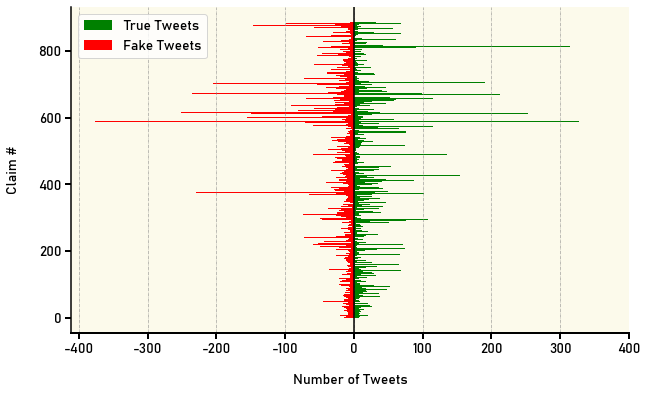

In [24]:
# Calculate the offset for positioning the bars
offset = claim_counts[0]

# Plotting the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
plt.barh(claim_counts.index, claim_counts[0], label='True Tweets', height=3, color='green')
plt.barh(claim_counts.index, -claim_counts[1], label='Fake Tweets', height=3, color='red')

# Add a vertical line at the center
plt.axvline(0, color='black', linewidth=1.5)

ax.set_xlabel('Number of Tweets', labelpad=18, font=font_prop_labels)
ax.set_ylabel('Claim #', labelpad=18, font=font_prop_labels)

ax.set_xticks(range(-400, 401, 100))
ax.set_xticklabels(ax.get_xticks(), font=font_prop_yticks)

ax.set_yticks(range(0, 801, 200))
ax.set_yticklabels(ax.get_yticks(), font=font_prop_yticks)

plt.legend()
ax.legend(prop=font_prop_legend)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(1.5)

ax.tick_params(axis='x', which='both', width=2, length=6)
ax.tick_params(axis='y', which='both', width=2, length=6)

ax.set_facecolor('#FCFAEB')
ax.yaxis.grid(True, linestyle='-.', linewidth=0.5, color='gray')
ax.xaxis.grid(True, linestyle='-.', linewidth=0.5, color='gray')
plt.grid(axis='y')

#plt.savefig('04-analysis-figs/number-of-tweets-per-claim.png', dpi=300)
plt.show()

#### Counts of Fake and True Tweets

In [25]:
# Calculate the count of fake and true tweets
fake_tweets_count = df[df['label'] == True]['tweet_id'].count()
true_tweets_count = df[df['label'] == False]['tweet_id'].count()
counts = [fake_tweets_count, true_tweets_count]

for i, count in enumerate(counts):
    print(i, count)

0 11076
1 9008


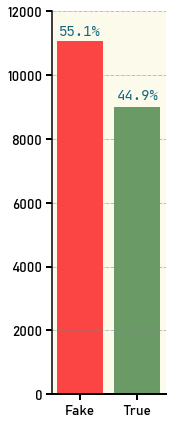

In [26]:
labels = ['Fake', 'True']

plt_chart(labels, counts, 'number-of-true-fake-tweets', '', '', data_annotations=[(11200, '55.1%'), (9200, '44.9%')],
          xticks_text=True, xticks_angel=0, yticks_start=0, yticks_step=2000, width=2.5, height=6, colors=['FB4444', '6A9B67'])

In [27]:
# Get the list of users and their tweet counts
tweets_per_user = df.groupby('user_id')['tweet_id'].count()
users = tweets_per_user.index
tweet_counts = tweets_per_user.values

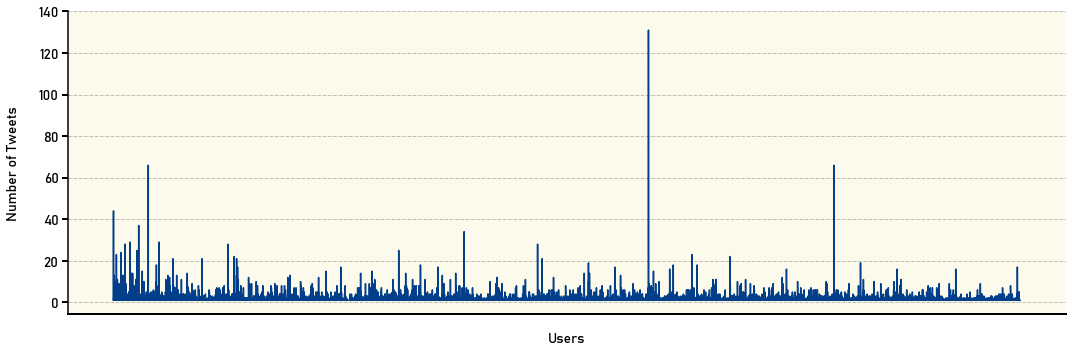

In [28]:
plt_chart(list(range(len(users))), tweet_counts, 'number-of-tweets-per-user', 'Users', 'Number of Tweets', chart_type='plot',
          show_xticks=False, yticks_start=0, yticks_step=20, width=15, height=5)

In [29]:
# How many users participated with more than one tweet
len(tweets_per_user[tweets_per_user > 1])

2653

### Textual Analysis

In [30]:
df['annotations_type'] = df['annotations_type'].apply(ast.literal_eval)

In [31]:
df['annotations_text'] = df['annotations_text'].apply(ast.literal_eval)

In [32]:
df['organizations'] = df['organizations'].apply(ast.literal_eval)

In [33]:
df['persons'] = df['persons'].apply(ast.literal_eval)

In [34]:
df['places'] = df['places'].apply(ast.literal_eval)

In [35]:
df['products'] = df['products'].apply(ast.literal_eval)

In [36]:
df['hashtags'] = df['hashtags'].apply(ast.literal_eval)

In [37]:
df['emojis_count'] = df['emojis_count'].apply(ast.literal_eval)

In [38]:
df['context_domain'] = df['context_domain'].apply(ast.literal_eval)

In [39]:
df['context_entity'] = df['context_entity'].apply(ast.literal_eval)

In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Mohamed A.
[nltk_data]     Mostafa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
# Load the Arabic stop words
stop_words = set(stopwords.words('arabic'))

In [42]:
def text_to_word_cloud(text, is_arabic=True):
    words = text.split()

    # Remove stop words or words len < 3
    words = [word for word in words if word.lower() not in stop_words and len(word) > 2]
    text = ' '.join(words)
    if is_arabic:
        text = get_display(arabic_reshaper.reshape(str(text)))
    
    plt.imshow(WordCloud(font_path=fonts['majalla'], background_color='white').generate(text))
    plt.axis("off")
    plt.title('')
    plt.show()

In [43]:
def list_to_word_cloud(lst, is_arabic=True):
    text_reshaped = []
    for item in lst:
        if item not in stop_words and len(item) > 2:
            try:
                if is_arabic:
                    text_reshaped.append(get_display(arabic_reshaper.reshape(item)))
                else:
                    text_reshaped.append(item)
            except:
                pass
    text_counter = Counter(text_reshaped)
    plt.imshow(WordCloud(font_path=fonts['majalla'], background_color='white').generate_from_frequencies(text_counter))
    plt.axis("off")
    plt.title('')
    plt.show() 

In [44]:
def emojis_to_word_cloud(dic):
    plt.imshow(WordCloud(font_path=fonts['emojis-font'], background_color='white').generate_from_frequencies(dic))
    plt.axis("off")
    plt.title('')
    plt.show() 

#### Display word cloud of text_arabic of tweet

In [45]:
text_arabic = ' '.join(df['text_arabic'])

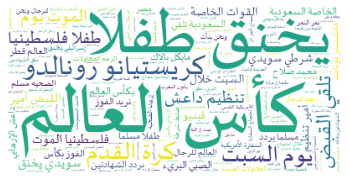

In [46]:
text_to_word_cloud(text_arabic)

#### edits remaining

In [47]:
df['edits_remaining'].sample(10)

13312    5
15225    5
10133    5
9054     5
13576    5
14386    5
18269    5
12908    5
11206    5
860      5
Name: edits_remaining, dtype: int64

In [48]:
edits_remaining = df['edits_remaining'].value_counts()
edits_remaining

edits_remaining
5    20024
4       53
3        5
0        1
2        1
Name: count, dtype: int64

In [49]:
df['tweet_edits'] = 5 - df['edits_remaining']
df['tweet_edits'].sample(5)

3475     0
7748     0
13423    0
8268     0
6681     0
Name: tweet_edits, dtype: int64

In [50]:
df.drop('edits_remaining', axis=1, inplace=True)

#### count of possibly sensitive

In [51]:
df['possibly_sensitive'].value_counts()

possibly_sensitive
False    19308
True       776
Name: count, dtype: int64

#### annotation_type

In [52]:
df[['annotations_type', 'annotations_count', 'organizations_count', 'persons_count', 'places_count', 'products_count']].sample(10)

,annotations_type,annotations_count,organizations_count,persons_count,places_count,products_count
11417,[],0,0,0,0,0
426,[],0,0,0,0,0
9723,"[Place, Place, Place]",3,0,0,3,0
6521,[],0,0,0,0,0
2515,[],0,0,0,0,0
6775,[Place],1,0,0,1,0
7670,[Place],1,0,0,1,0
13849,"[Organization, Place, Product]",3,1,0,1,1
10816,"[Place, Place, Place, Place]",4,0,0,4,0
1797,"[Person, Organization, Person, Person, Person, Organization]",6,2,4,0,0


In [53]:
annotations_type = df[['organizations_count', 'persons_count', 'places_count', 'products_count']].sum()
annotations_type

organizations_count     3137
persons_count           7144
places_count           11499
products_count           221
dtype: int64

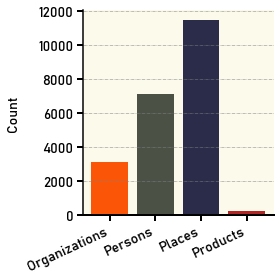

In [54]:
annotation = ['Organizations', 'Persons', 'Places', 'Products']
counts = [3137, 7144, 11499, 221]

plt_chart(annotation, counts, title='Annotations Count', xlabel='', xticks_align='right', ylabel='Count', yticks_step=2000 , 
          xticks_text=True, xticks_angel=25, width=4, height=4, colors=['fb5607', '4c5146', '2b2c49', 'b42626'])

#### annotations text counter

In [55]:
annotations_text_list = []
for index, row in df.iterrows():
    sub_list = row['annotations_text']
    annotations_text_list += sub_list

In [56]:
annotations_text_list[:5]

['مجلس الأمن الروسي', 'صلاح', 'نابولي', 'ليكيب', 'كريستيانو رونالدو']

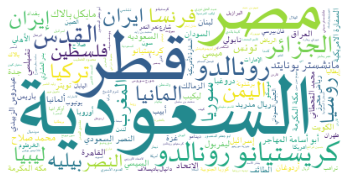

In [57]:
list_to_word_cloud(annotations_text_list)

In [58]:
annotations_text_count = Counter(annotations_text_list)

In [59]:
top_annotations_text = annotations_text_count.most_common(10)

In [60]:
y_items = [get_display(arabic_reshaper.reshape(item[0])) for item in top_annotations_text]
x_width = [item[1] for item in top_annotations_text]
y_items.reverse()
x_width.reverse()

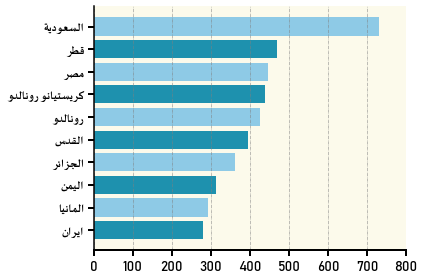

In [61]:
plt_bar_chart(y_items, x_width, title='most freq annotation words', xlabel='', ylabel='', show_title=False, show_xticks=True, 
          show_yticks=True, data_annotations=None, yticks_text=True, yticks_angel=0, is_arabic_text=True,
              xticks_start=0, xticks_step=100, grid='y', width=6, height=4, colors=['1E91AE', '8ECAE6'])

#### organizations counter

In [62]:
organizations_list = []
for index, row in df.iterrows():
    sub_list = row['organizations']
    organizations_list += sub_list

organizations_list[:5]

['مجلس الأمن الروسي', 'البرتغال', 'الزمالك', 'تشيلسي', 'وزارة التعليم']

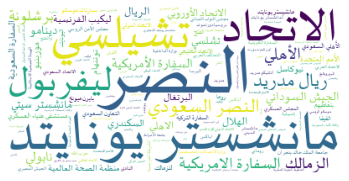

In [63]:
list_to_word_cloud(organizations_list)

In [64]:
organizations_count = Counter(organizations_list)

In [65]:
top_organizations_count = organizations_count.most_common(10)

In [66]:
y_items = [get_display(arabic_reshaper.reshape(item[0])) for item in top_organizations_count]
x_width = [item[1] for item in top_organizations_count]
y_items.reverse()
x_width.reverse()

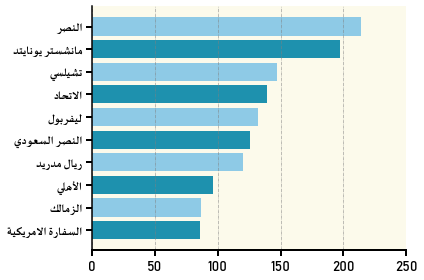

In [67]:
plt_bar_chart(y_items, x_width, title='most freq organizations words', xlabel='', ylabel='', show_title=False, show_xticks=True, 
          show_yticks=True, data_annotations=None, yticks_text=True, yticks_angel=0, is_arabic_text=True,
              xticks_start=0, xticks_step=50, grid='y', width=6, height=4, colors=['1E91AE', '8ECAE6'])

#### persons counter

In [68]:
persons_list = []
for index, row in df.iterrows():
    sub_list = row['persons']
    persons_list += sub_list

persons_list[:5]

['صلاح', 'ليكيب', 'كريستيانو رونالدو', 'آرسين فينجر', 'نيمار']

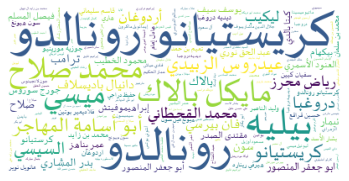

In [69]:
list_to_word_cloud(persons_list)

In [70]:
persons_count = Counter(persons_list)

In [71]:
top_persons_count = persons_count.most_common(10)

In [72]:
y_items = [get_display(arabic_reshaper.reshape(item[0])) for item in top_persons_count]
x_width = [item[1] for item in top_persons_count]
y_items.reverse()
x_width.reverse()

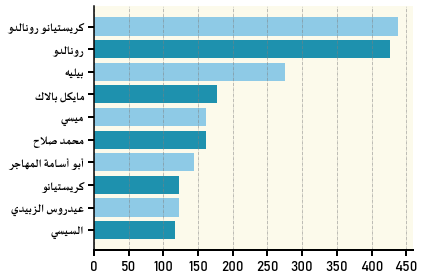

In [73]:
plt_bar_chart(y_items, x_width, title='most freq persons words', xlabel='', ylabel='', show_title=False, show_xticks=True, 
          show_yticks=True, data_annotations=None, yticks_text=True, yticks_angel=0, is_arabic_text=True,
              xticks_start=0, xticks_step=50, grid='y', width=6, height=4, colors=['1E91AE', '8ECAE6'])

#### places counter

In [74]:
places_list = []
for index, row in df.iterrows():
    sub_list = row['places']
    places_list += sub_list

places_list[:5]

['نابولي', 'باريس', 'السودان', 'السعودية', 'بيشاور']

In [75]:
for i in range(len(places_list)):
    if places_list[i] == 'إيران':
        places_list[i] = 'ايران'

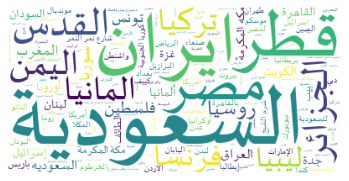

In [76]:
list_to_word_cloud(places_list)

In [77]:
places_count = Counter(places_list)

In [78]:
top_places_count = places_count.most_common(10)

In [79]:
y_items = [get_display(arabic_reshaper.reshape(item[0])) for item in top_places_count]
x_width = [item[1] for item in top_places_count]
y_items.reverse()
x_width.reverse()

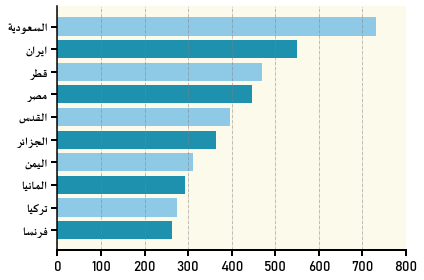

In [80]:
plt_bar_chart(y_items, x_width, title='most freq places words', xlabel='', ylabel='', show_title=False, show_xticks=True, 
          show_yticks=True, data_annotations=None, yticks_text=True, yticks_angel=0, is_arabic_text=True,
              xticks_start=0, xticks_step=100, grid='y', width=6, height=4, colors=['1E91AE', '8ECAE6'])

#### products counter

In [81]:
products_list = []
for index, row in df.iterrows():
    sub_list = row['products']
    products_list += sub_list

products_list[:5]

['تويتر', 'تويتر', 'تويتر', 'تويتر', 'تويتر']

In [82]:
for i in range(len(products_list)):
    if products_list[i] == 'اليوتيوب':
        products_list[i] = 'يوتيوب'
    if products_list[i] in ('إنستغرام', 'انستجرام') :
        products_list[i] = 'انستغرام'

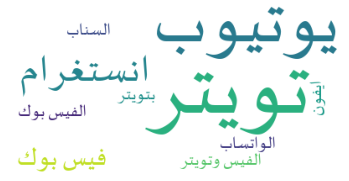

In [83]:
list_to_word_cloud(products_list)

In [84]:
products_count = Counter(products_list)

In [85]:
top_products_count = products_count.most_common(10)

In [86]:
y_items = [get_display(arabic_reshaper.reshape(item[0])) for item in top_products_count]
x_width = [item[1] for item in top_products_count]
y_items.reverse()
x_width.reverse()

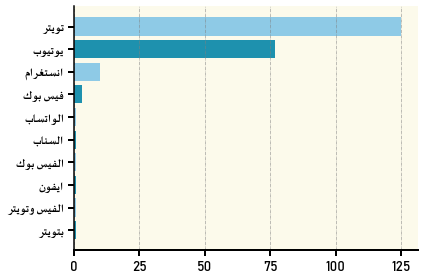

In [87]:
plt_bar_chart(y_items, x_width, title='most freq products words', xlabel='', ylabel='', show_title=False, show_xticks=True, 
          show_yticks=True, data_annotations=None, yticks_text=True, yticks_angel=0, is_arabic_text=True,
              xticks_start=0, xticks_step=25, grid='y', width=6, height=4, colors=['1E91AE', '8ECAE6'])

#### hashtags counter

In [88]:
hashtags_list = []
for index, row in df.iterrows():
    sub_list = row['hashtags']
    hashtags_list += sub_list

hashtags_list = ['#'+ h for h in hashtags_list]
hashtags_list[:10]

['#وهران',
 '#المغرب',
 '#روسيا',
 '#تركيا',
 '#حلب',
 '#رئيس_الوزراء_البريطاني',
 '#الملك_تشارلز_الثالث',
 '#فك_اللجام',
 '#ناس_الشجرة_بسلمو_عليكم',
 '#هبباي6أبريل']

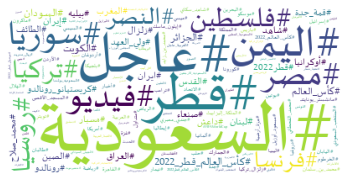

In [89]:
list_to_word_cloud(hashtags_list)

In [90]:
hashtags_count = Counter(hashtags_list)

In [91]:
top_hashtags_count = hashtags_count.most_common(10)

In [92]:
y_items = [get_display(arabic_reshaper.reshape(item[0])) for item in top_hashtags_count]
x_width = [item[1] for item in top_hashtags_count]
y_items.reverse()
x_width.reverse()

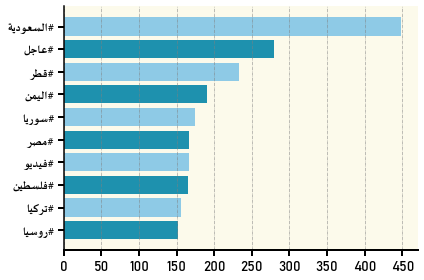

In [93]:
plt_bar_chart(y_items, x_width, title='most freq hashtags', xlabel='', ylabel='', show_title=False, show_xticks=True, 
          show_yticks=True, data_annotations=None, yticks_text=True, yticks_angel=0, is_arabic_text=True,
              xticks_start=0, xticks_step=50, grid='y', width=6, height=4, colors=['1E91AE', '8ECAE6'])

#### emojis counter

In [94]:
emojis_dict = {}
for index, row in df.iterrows():
    sub_list = row['emojis_count']
    for key, value in sub_list.items():
        emojis_dict[key] = emojis_dict.get(key, 0) + value

In [95]:
first_10_items = dict(list(emojis_dict.items())[:10])
first_10_items

{'😱': 82,
 '😰': 18,
 '😳': 131,
 '🤦\u200d♂️': 18,
 '😅': 159,
 '🚨': 1767,
 '😨': 29,
 '💙': 128,
 '🗣️': 67,
 '🎥': 83}

In [96]:
emojis_count_list = sorted(emojis_dict.items(), key=lambda x: x[1], reverse=True)

In [97]:
emojis_count_list[:10]

[('🚨', 1767),
 ('😂', 1120),
 ('🔴', 616),
 ('🔥', 535),
 ('💔', 474),
 ('👇', 465),
 ('❤️', 435),
 ('❗', 392),
 ('🇸🇦', 356),
 ('🤣', 346)]

In [98]:
emojis_dict = {key: value for key, value in emojis_count_list}

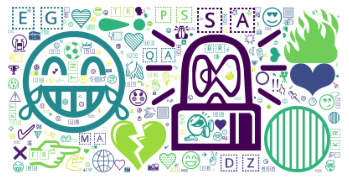

In [99]:
emojis_to_word_cloud(emojis_dict)

In [100]:
y_items = [emoji[0] for emoji in emojis_count_list[:10]]
x_width = [emoji[1] for emoji in emojis_count_list[:10]]
y_items.reverse()
x_width.reverse()

In [101]:
y_items[:10]

['🤣', '🇸🇦', '❗', '❤️', '👇', '💔', '🔥', '🔴', '😂', '🚨']

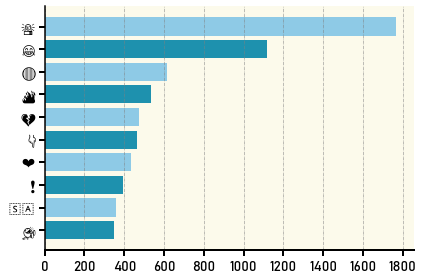

In [102]:
plt_bar_chart(y_items, x_width, title='most freq emojis', xlabel='', ylabel='', show_title=False, show_xticks=True, 
          show_yticks=True, data_annotations=None, yticks_text=True, yticks_angel=0, is_arabic_text=False,
              xticks_start=0, xticks_step=200, grid='y', width=6, height=4, colors=['1E91AE', '8ECAE6'], is_emoji=True)

#### context domain

In [103]:
df[['text', 'context_domain', 'context_entity']].sample(10)

,text,context_domain,context_entity
8387,الشرطة الهولندية تدرب النسور لإسقاط الطائرات بدون طيار.\nhttps://t.co/OEsVQ6M2hl,[],[]
7898,تفيد شهادات برؤية جرم احترق في سماء #المدينة قرابة الساعة ١٠ مساءً \nمن وصف الشهود احترق سريعا ولونه يميل للأخضر \nغالبا هو نيزك احترق بالغلاف الجوي او مايسمى علميا ( #كرة_نارية ) \nولا يمكن تأكيد الامر حتى نحصل على فيديوهات او صور له \nلا يوجد أي بيانات لسقوط اقمار صناعية بذلك الوقت… https://t.co/Bf1C5HCMxw https://t.co/Q8smCY8ZFM,[],[]
12564,في الوقت الذي قنوات_الصرف الصحي مشغولة بتصفير الجمهور على رابح ماجر\nوخراقة يناير و مسابقة ملكات الخرطي\nطلبة جامعة الأغواط يشرفون الجزائر، و يحتلون المرتبة 3 من بين 110 جامعة بعد الفوز على جامعة هارفورد في مناظرات الجامعات\nطلبة جامعة الأغواط قدموا مناظرتهم باللغة العربية\n# منقول https://t.co/uVPSg3Ki20,[],[]
9208,تداول عدد كبير من النشطاء على مواقع التواصل الاجتماعي هذه الصورة، التي وصفها العديد من الأشخاص بأنه عد تنازلي مجهول في روسيا.\n\nالحقيقة: القنوات الروسية بثت هذه الصورة وأسفلها العد التنازلي يوم الاثنين 20 فبراير تمهيدا لخطاب الرئيس الروسي يوم 21 فبراير الذي أذيع أمس الثلاثاء. https://t.co/v22s067Von,[],[]
10305,@Russianowarabic خبر مضلل..!!\nروعي كايس مين يا بقر ، \nصورة محمد صلاح مع صديقه محمد عرفي حتى الصحفي الإسرائيلي ما قال أن الصورة معاه.,"[Business Taxonomy, Person, Athlete, Unified Twitter Taxonomy, Unified Twitter Taxonomy, Unified Twitter Taxonomy]","[Sports & Fitness Business, Mohamed Salah, Mohamed Salah, Soccer, Mohamed Salah, Sports]"
12456,هكذا استقبلت #غزة الفجر!\nبغارات المقاتلات الحربية الأكثر فتكاً، التي تزود بها أمريكا دولة الاحتلال ليمارس عدوانه على أكبر تجمع بشري مدني في العالم!\nفي ظل صمت دولي وعربي، ولا نسمع إدانتهم إلا عندما نمارس المق١ومة التي كفلتها لنا الشرائع والقوانين كافة، بل إن البعض رمانا بالإرهاب! https://t.co/OclC8rNy5J,[],[]
955,فيلق عمر الفاروق يتوجه الى الحدود بأذن الله راح يدورون رأس المجوس #طالبان_زند_باد https://t.co/wDSt24lvOF,[],[]
13764,@AJArabic 🌐- ضابط شرطة إسرائيلي يخنق طفلا فلسطينيا حتى الموت يوم السبت خلال احتجاج السفارة الأمريكية في القدس.حتى أن الصبي البريء نطق الشهادتين قبل وفاته. وعلى الرغم من المحاولات العديدة التي قامت بهاالمجموعات لتحميل هذاالفيديو على يوتيوب، فقد تمت إزالته بشكل منهجي من جوجل وفيسبوك ويوتيوب https://t.co/JibpCObvPE,"[Brand Vertical, Entities [Entity Service], Entities [Entity Service], Brand, Brand, Unified Twitter Taxonomy]","[Entertainment, Services, TV/Movies Related - Entertainment, Google , Al Jazeera, Google ]"
1130,#شاهد : #رياض_محرز يرفع علم #فلسطين 🇵🇸 خلال تتويج #السيتي بـ #الدوري_الإنجليزي\n\nلتخطي الحجب: https://t.co/hx7LwKI1qy\nللمزيد: https://t.co/I7xnYdeb8W\n#مباشر #ربيع_فلسطين,"[TV Shows, Sport, Sports League, Brand Vertical, Entities [Entity Service], Brand, Unified Twitter Taxonomy, Unified Twitter Taxonomy, Unified Twitter Taxonomy, Person, Athlete, Unified Twitter Taxonomy, Unified Twitter Taxonomy, Unified Twitter Taxonomy, Events [Entity Service], News Vertical, Unified Twitter Taxonomy]","[Premier League, Soccer, Premier League, Entertainment, TV/Movies Related - Entertainment, Al Jazeera, Premier League, Soccer, Sports, Riyad Mahrez, Riyad Mahrez, Soccer, Riyad Mahrez, Sports, Premier League, World news, World news]"
6925,⚽️ احتفالات شعبية غير مسبوقة في العاصمة والمحافظات ابتهاجاً بفوز المنتخب الوطني وهزيمة المنتخب السعودي*,"[Sports Team, Unified Twitter Taxonomy, Unified Twitter Taxonomy, Unified Twitter Taxonomy]","[Saudi Arabia, Saudi Arabia, Soccer, Sports]"


In [104]:
context_domain_list = []
for index, row in df.iterrows():
    sub_list = row['context_domain']
    context_domain_list += sub_list

context_domain_list[:5]

['Business Taxonomy',
 'Business Taxonomy',
 'Sports League',
 'Business Taxonomy',
 'Unified Twitter Taxonomy']

In [105]:
context_domain_count = Counter(context_domain_list).most_common()
list(context_domain_count)[:10]

[('Unified Twitter Taxonomy', 22623),
 ('Business Taxonomy', 4438),
 ('Sports League', 3298),
 ('Person', 3294),
 ('Events [Entity Service]', 2673),
 ('Sports Team', 2273),
 ('Sports Event', 1948),
 ('Athlete', 1860),
 ('Brand', 1740),
 ('Sport', 1663)]

In [106]:
context_entity_list = []
for index, row in df.iterrows():
    sub_list = row['context_entity']
    context_entity_list += sub_list

context_entity_list[:5]

['Food & Beverage Business',
 'Gaming Business',
 "FIFA Men's World Cup",
 'Sports & Fitness Business',
 'Soccer']

In [107]:
context_entity_count = Counter(context_entity_list).most_common()
list(context_entity_count)[:10]

[('Soccer', 5659),
 ('Sports', 4202),
 ('Sports & Fitness Business', 3269),
 ('Cristiano Ronaldo', 2808),
 ('2022 FIFA World Cup', 2265),
 ("FIFA Men's World Cup", 1850),
 ('Premier League', 1446),
 ('Events', 926),
 ('Sports events', 921),
 ('Politics', 883)]

#### content features

In [108]:
content_features = ['edits_remaining', 'possibly_sensitive', 'annotations_type',
                    'annotations_count', 'organizations', 'organizations_count',
                    'persons', 'persons_count', 'places', 'places_count', 
                    'products', 'products_count', 'annotations_text', 'is_edit_eligible',
                    'context_domain', 'context_domain_desc', 'context_entity', 
                    'context_entity_desc', 'text_arabic', 'text_length', 'emojis', 
                    'emojis_count', 'emojis_total_count', 'hashtags', 'hashtags_count']

### Temporal Analysis

#### Tweets timeline

In [109]:
df['created_at'].head()

0    2023-09-02T12:30:22.000Z
1    2023-09-02T11:32:11.000Z
2    2023-02-01T16:08:54.000Z
3    2022-09-30T23:59:00.000Z
4    2023-09-01T18:11:10.000Z
Name: created_at, dtype: object

In [110]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [111]:
# Create new column for month and year
df['tweet_year'] = df['created_at'].dt.strftime('%Y')

In [112]:
df['tweet_year'].head()

0    2023
1    2023
2    2023
3    2022
4    2023
Name: tweet_year, dtype: object

In [113]:
yearly_tweets = df.groupby('tweet_year')['tweet_id'].count()

In [114]:
yearly_tweets

tweet_year
2008       1
2011      11
2012      23
2013      91
2014     116
2015     495
2016     574
2017     408
2018     374
2019     813
2020     642
2021     865
2022    7557
2023    8114
Name: tweet_id, dtype: int64

In [115]:
data_annotations=[[(i, str(count))] for i, count in yearly_tweets.items()]

In [116]:
len(data_annotations)

14

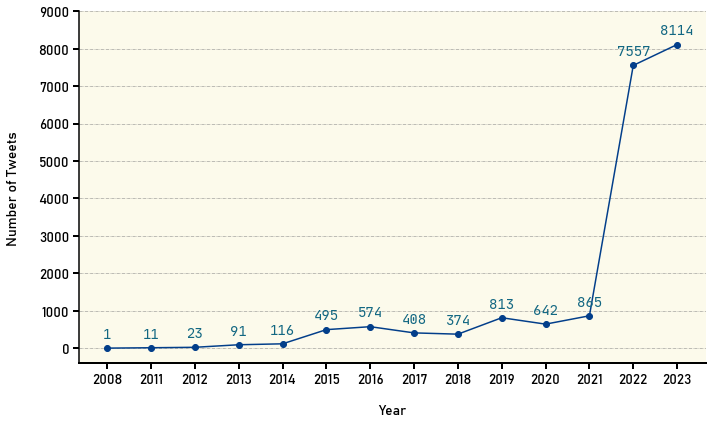

In [117]:
plt_chart(yearly_tweets.index, yearly_tweets.values, title='tweets-timeline', xlabel='Year', ylabel='Number of Tweets', show_title=False, show_xticks=True, show_yticks=True,
              data_annotations='y-values', chart_type='plot', xticks_text=True, xticks_angel=0, yticks_start=0, 
              yticks_step=1000, grid='x', width=10, height=6, colors=colors_blue_mono, marker='o')

#### user accounts timeline

In [118]:
df['user_created_at'].head()

0    2023-08-06T17:25:40.000Z
1    2012-02-14T13:58:41.000Z
2    2012-02-14T13:58:41.000Z
3    2012-02-14T13:58:41.000Z
4    2022-09-03T14:14:16.000Z
Name: user_created_at, dtype: object

In [119]:
df['user_created_at'] = pd.to_datetime(df['user_created_at'])

In [120]:
# Create new column for month and year
df['user_year'] = df['user_created_at'].dt.strftime('%Y')

In [121]:
df['user_year'].head()

0    2023
1    2012
2    2012
3    2012
4    2022
Name: user_year, dtype: object

In [122]:
yearly_users = df.groupby('user_year')['user_id'].count()

In [123]:
yearly_users

user_year
2007      55
2008      59
2009     529
2010     758
2011    2162
2012    1805
2013    1282
2014    1136
2015    1048
2016     968
2017     910
2018     898
2019    1463
2020    1877
2021    2138
2022    2504
2023     492
Name: user_id, dtype: int64

In [124]:
data_annotations=[[(i, str(count))] for i, count in yearly_tweets.items()]

In [125]:
len(data_annotations)

14

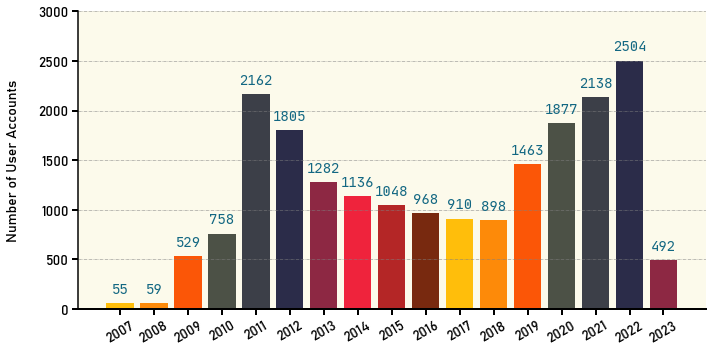

In [126]:
plt_chart(yearly_users.index, yearly_users.values, title='users-accounts-timeline', xlabel='', ylabel='Number of User Accounts', show_title=False, show_xticks=True, show_yticks=True,
              data_annotations='y-values', chart_type='bar', xticks_text=True, xticks_angel=30, yticks_start=0, 
              yticks_step=500, grid='x', width=10, height=5, colors=colors_mix, marker='o')

In [127]:
# Calculate the difference of user account in months
df['user_acc_months_age'] = df.apply(lambda row: (row['created_at'].year - row['user_created_at'].year) * 12 + (row['created_at'].month - row['user_created_at'].month), axis=1)

In [128]:
user_acc_months_age = df['user_acc_months_age'].value_counts()

In [129]:
user_acc_months_age[:10]

user_acc_months_age
1     441
2     361
3     319
15    316
0     296
4     293
8     282
10    268
7     267
6     257
Name: count, dtype: int64

In [130]:
user_acc_months_age_sorted = user_acc_months_age.sort_index(ascending=True)

In [131]:
user_acc_months_age_sorted[:10]

user_acc_months_age
0    296
1    441
2    361
3    319
4    293
5    246
6    257
7    267
8    282
9    230
Name: count, dtype: int64

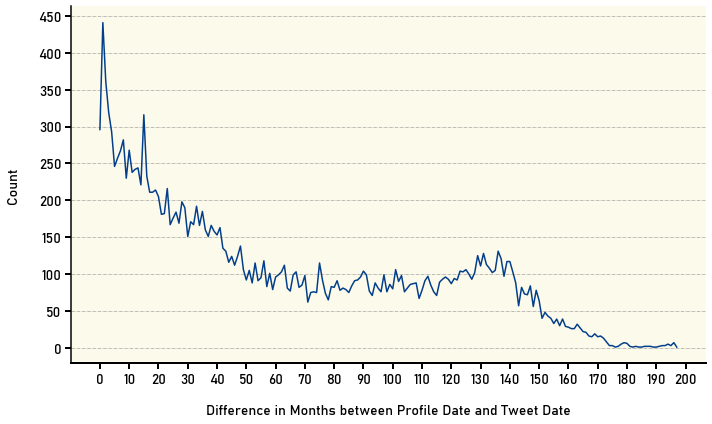

In [132]:
plt_chart(user_acc_months_age_sorted.index, user_acc_months_age_sorted.values, title='users-accounts-monhts-age',
          xlabel='Difference in Months between Profile Date and Tweet Date', ylabel='Count', show_title=False, show_xticks=True, show_yticks=True,
          data_annotations=None, chart_type='plot', xticks_text=False, xticks_angel=0, 
          xticks_step=10, yticks_start=0, yticks_step=50, grid='x', width=10, height=6, colors=colors_blue_mono)

#### User Locations

In [133]:
df['location'].head()

0                       مراكش 
1                          NaN
2                          NaN
3                          NaN
4    Leo Messi - New Brunswick
Name: location, dtype: object

In [134]:
df_iso_3 = pd.read_excel('data/05-VERA-ARB-locations-iso-mapping.xlsx')
df_iso_3.head()

,location,iso_a3
0,Afghanistan,AFG
1,کابل. افغانستان,AFG
2,"Casablanca, Grand Casablanca",APR
3,الدار البيضاء - المغرب,APR
4,الشارقة,AR


In [135]:
merged_loc_df = pd.merge(df['location'], df_iso_3, on='location', how='outer')

In [136]:
merged_loc_df.shape

(20087, 2)

In [137]:
locations = merged_loc_df['iso_a3'].value_counts()

In [138]:
locations[:15]

iso_a3
SAU    2448
EGY    1198
KWT     994
YEM     706
ARE     551
IRQ     524
LBN     397
QAT     373
JOR     361
USA     347
PSE     313
DZA     285
GBR     242
SYR     197
MAR     180
Name: count, dtype: int64

In [139]:
# Read the world shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\MOHAME~1.MOS\AppData\Local\Temp/ipykernel_17148/2908406010.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [140]:
world.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000 -16.55522, 179.36414 -16.80135, 178.72506 -17.01204, 178.59684 -16.63915, 179.09661 -16.43398, 179.41351 -16.37905, 180.00000 -16.06713)), ((178.12557 -17.50481, 178.37360 -17.33992, 178.71806 -17.62846, 178.55271 -18.15059, 177.93266 -18.28799, 177.38146 -18.16432, 177.28504 -17.72465, 177.67087 -17.38114, 178.12557 -17.50481)), ((-179.79332 -16.02088, -179.91737 -16.50178, -180.00000 -16.55522, -180.00000 -16.06713, -179.79332 -16.02088)))"
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982, 37.69869 -3.09699, 37.76690 -3.67712, 39.20222 -4.67677, 38.74054 -5.90895, 38.79977 -6.47566, 39.44000 -6.84000, 39.47000 -7.10000, 39.19469 -7.70390, 39.25203 -8.00781, 39.18652 -8.48551, 39.53574 -9.11237, 39.94960 -10.09840, 40.31659 -10.31710, 40.31659 -10.31710, 39.52100 -10.89688, 38.42756 -11.28520, 37.82764 -11.26879, 37.47129 -11.56876, 36.77515 -11.59454, 36.51408 -11.72094, 35.31240 -11.43915, 34.55999 -11.52002, 34.28000 -10.16000, 33.94084 -9.69367, 33.73972 -9.41715, 32.75938 -9.23060, 32.19186 -8.93036, 31.55635 -8.76205, 31.15775 -8.59458, 30.74001 -8.34001, 30.74002 -8.34001, 30.20000 -7.07998, 29.62003 -6.52002, 29.41999 -5.94000, 29.51999 -5.41998, 29.34000 -4.49998, 29.75351 -4.45239, 30.11632 -4.09012, 30.50554 -3.56858, 30.75224 -3.35931, 30.74301 -3.03431, 30.52766 -2.80762, 30.46967 -2.41385, 30.46967 -2.41383, 30.75831 -2.28725, 30.81613 -1.69891, 30.41910 -1.13466, 30.76986 -1.01455, 31.86617 -1.02736, 33.90371 -0.95000))"
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948, -8.68440 27.39574, -8.68729 25.88106, -11.96942 25.93335, -11.93722 23.37459, -12.87422 23.28483, -13.11875 22.77122, -12.92910 21.32707, -16.84519 21.33332, -17.06342 20.99975, -17.02043 21.42231, -17.00296 21.42073, -14.75095 21.50060, -14.63083 21.86094, -14.22117 22.31016, -13.89111 23.69101, -12.50096 24.77012, -12.03076 26.03087, -11.71822 26.10409, -11.39255 26.88342, -10.55126 26.99081, -10.18942 26.86094, -9.73534 26.86094, -9.41304 27.08848, -8.79488 27.12070, -8.81783 27.65643, -8.66559 27.65643))"


In [141]:
merged = world.merge(locations[locations > 10], on='iso_a3', how='inner')

In [142]:
m = folium.Map(location=[58.4052172,-109.6062729],zoom_start=2.5, scrollWheelZoom=False, dragging=True, tiles="cartoDB positron")

for i,r in merged.iterrows():
    folium.Circle(
        location=[r['geometry'].centroid.y,r['geometry'].centroid.x],
        radius = float(r['count'])*400,
        fill=True,
        fill_color='#824D13',
        fill_opacity=0.5,
        line_opacity=0.9,
        popup=f"{r['name']}: {r['count']}",
        color = None #'blue' if r['name'] not in territories else 'crimson'
        ).add_to(m)

m

In [143]:
# Assuming you have a merged DataFrame named 'merged' with geometry, count, name columns

# Create a map object
m2 = folium.Map(location=[58.4052172, -109.6062729], zoom_start=2.5, tiles='CartoDB positron', scrollWheelZoom=False, dragging=True)

# Create a Choropleth layer with the count data
choropleth_layer = folium.Choropleth(
    geo_data='data/world-countries.json', #'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json',
    name='count',
    data=merged,
    columns=['name', 'count'],
    key_on='feature.properties.name',
    fill_color='PuBu',
    fill_opacity=0.6,
    line_opacity=0.05,
    bins=[11, 50, 102, 400, 2448],
    legend_name='Count',
    highlight=True,
    nan_fill_color='white'
).add_to(m2)

# Add the Choropleth layer to the map
folium.LayerControl().add_to(m2)

# Display the map
m2

### User engagement analysis

#### stats

In [144]:
df['followers_count'].mean()

399304.5326628162

In [145]:
df['following_count'].mean()

3904.2786297550288

In [146]:
df['tweet_count'].mean()

74049.65723959371

In [147]:
df['listed_count'].mean()

365.2375522804222

#### Average followers count

In [148]:
df['followers_count'].max()

24215822

#### Average followings count

In [151]:
df['following_count'].max()

2040314

#### Average tweets count

In [154]:
df['tweet_count'].max()

2547349

#### Average listed count

In [157]:
df['listed_count'].max()

29885

#### Average user like count

In [160]:
df['user_like_count'].max()

1439823

### Network analysis

#### stats

In [163]:
df['impression_count'].mean()

32157.301035650267

In [164]:
df['bookmark_count'].mean()

3.4278530173272257

In [165]:
df['quote_count'].mean()

4.288587930691097

In [166]:
df['like_count'].mean()

115.79321848237403

In [167]:
df['reply_count'].mean()

14.358145787691695

In [168]:
df['retweet_count'].mean()

25.22366062537343

In [169]:
# Calculate the difference of user account in months
df['tweet_months_age'] = df.apply(lambda row: (2024 - row['created_at'].year) * 12 + (1 - row['created_at'].month), axis=1)

#### Average impressions count

In [170]:
df['impression_count'].mean()

32157.301035650267

#### Average bookmark count

In [173]:
df['bookmark_count'].mean()

3.4278530173272257

#### Average quote count

In [176]:
df['quote_count'].mean()

4.288587930691097

#### Average like count

In [179]:
df['like_count'].mean()

115.79321848237403

#### Average reply count

In [182]:
df['reply_count'].mean()

14.358145787691695

#### Average retweet count

In [185]:
df['retweet_count'].mean()

25.22366062537343

In [188]:
from pytz import utc

In [189]:
df['created_at'] = df['created_at'].dt.tz_convert(utc).dt.tz_localize(None)

In [190]:
df['user_created_at'] = df['user_created_at'].dt.tz_convert(utc).dt.tz_localize(None)

In [191]:
df['tweet_id'] = df['tweet_id'].astype(str)

In [193]:
df.to_excel('data/06-VERA-ARB-Dataset.xlsx', index=False)